# Approximation d’images PNG vers SVG à l’aide d’algorithmes évolutionnaires

**Auteur :** SADOK Zakary, Axel Ozange<br/>
**UE :** Optimisation<br/>
**Date :** 26/01/2026<br/>

---

## Résumé

Ce projet vise à approximer une image raster (PNG/JPG) par un ensemble limité
de formes géométriques vectorielles (SVG).

Deux approches sont étudiées et comparées :
1. un algorithme génétique (GA),
2. une approche gloutonne guidée par l’erreur avec raffinement local.

L’objectif est de produire une image SVG esthétiquement plaisante sous
contraintes de temps et de nombre de formes.


## Énoncé du problème

Étant donnée :
- une image source raster,
- un nombre maximal de formes géométriques,
- un temps fixe,

nous cherchons à générer une image SVG autonome qui se rapproche visuellement
de l’image originale.

Ce problème est un **problème d’optimisation** :
la qualité de la solution doit s’améliorer continuellement avec le temps.

## User manual

### Command-line usage

```bash
python3 png2svg.py \
  --algo greedy \
  --shape rectangle \
  --n 150 \
  --time 60 \
  --input images/monalisa.jpg \
  --output out.svg
```
Parameters

--algo: greedy ou ga

--shape: rectangle, circle, ellipse, ou mixed

--n: nombre de formes

--time: limite de temps en secondes

## Conception des algorithmes

### Approche gloutonne (Greedy)

L’algorithme glouton se déroule en deux phases :

#### 1) Construction
- On ajoute itérativement **une forme à la fois**.
- Les formes candidates sont proposées **près des zones où l’erreur est élevée** (à l’aide d’une carte d’erreur).
- On sélectionne la forme candidate qui produit **la plus grande amélioration de la fitness** (réduction de l’erreur).

#### 2) Raffinement (Refinement)
- Une fois le budget de formes atteint (le nombre de formes max), l’algorithme réalise un **hill-climbing local** (recherche locale par petites mutations).
- À chaque itération, **une seule forme** est mutée.
- La mutation est **acceptée uniquement si** la fitness s’améliore (ou reste égale).

Cette stratégie combine une découverte rapide de la structure globale (construction) et une optimisation fine des détails (raffinement).

### Algorithme Génétique (baseline)

L’algorithme génétique maintient une **population** de candidats SVG. À chaque génération, il applique :

- une **sélection par tournoi** (tournament selection),
- des **mutations**,
- de l’**élitisme** (conservation des meilleurs individus).

En raison du **coût élevé de l’évaluation** (rendu + calcul de la fitness), la convergence est généralement **plus lente** que celle de l’approche gloutonne.

## Fonction de fitness

Nous utilisons une loss L1 pixel à pixel sur une version réduite de l’image.

Avantages :
- plus robuste que la MSE,
- moins sensible aux valeurs extrêmes,
- plus corrélée à la perception visuelle.

La réduction de résolution permet d’augmenter significativement
le nombre d’itérations possibles dans un temps donné.

---

## Analyse d’efficacité

Le coût dominant est l’évaluation de la fitness (rendu + comparaison).

Observations :
- la résolution réduite accélère fortement la convergence,
- l’approche gloutonne exploite mieux le temps,
- le GA gaspille du temps à évaluer des individus peu prometteurs.

L’approche gloutonne est plus efficace à temps égal.

## Comparaison des algorithmes

| Critère | Glouton | GA |
|-------|--------|----|
| Vitesse de convergence | Élevée | Faible |
| Qualité visuelle | Bonne | Moyenne |
| Utilisation du temps | Optimale | Sous-optimale |
| Stabilité | Forte | Faible |

Le GA est pénalisé par :
- le coût élevé de la fitness,
- des opérateurs de crossover destructifs,
- une dimensionnalité très élevée.

## Ablation study

- **Rectangles** produce a pixelized, mosaic-like result.
- **Circles** converge slower and blur edges.
- **Mixed shapes** create a painterly effect but require more time.

Rectangles offer the best quality-time trade-off for structured images.

## Réflexion sur les choix de conception

- Les algorithmes génétiques sont génériques mais mal adaptés ici.
- Le crossover détruit la cohérence spatiale des solutions.
- Une recherche incrémentale guidée par l’erreur est plus pertinente.
- Le raffinement local est indispensable pour exploiter le budget temps.

La simplicité algorithmique s’est révélée plus efficace que la complexité.

## Conclusion

Ce projet montre que :
- l’approche gloutonne avec raffinement local surpasse largement le GA pour ce type de problème,
- le choix de la stratégie d’optimisation est crucial,
- une bonne exploitation du temps est déterminante.

In [2]:
import sys
import os
from pathlib import Path

# Ensure project root is on path
PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import time
from IPython.display import SVG, display

In [3]:
from io_utils.image import load_image_bgr
from io_utils.svg import export_svg

from core.engine_greedy import GreedyEngine
from core.engine_ga import GAEngine

In [4]:
def run_experiment(
    image_path,
    algo="greedy",
    shape="rectangle",
    n_shapes=150,
    time_limit=60,
    scale=4,
    candidates=40,
    refine=0.6,
    pop=20,
    mut=0.25,
    seed=42,
    out_dir="outputs",
):
    os.makedirs(out_dir, exist_ok=True)

    target = load_image_bgr(image_path)

    if algo == "greedy":
        engine = GreedyEngine(
            target_bgr=target,
            shape_mode=shape,
            n_shapes=n_shapes,
            time_limit=time_limit,
            enable_viz=False,
            fitness_scale=scale,
            candidates_per_shape=candidates,
            refine_fraction=refine,
        )
    else:
        engine = GAEngine(
            target_bgr=target,
            shape_mode=shape,
            n_shapes=n_shapes,
            time_limit=time_limit,
            enable_viz=False,
            fitness_scale=scale,
            population_size=pop,
            mutation_rate=mut,
        )

    t0 = time.time()
    best = engine.run()
    elapsed = time.time() - t0

    out_svg = f"{out_dir}/{algo}_{shape}_{n_shapes}_{time_limit}s.svg"
    export_svg(out_svg, best, engine.width, engine.height, engine.background_bgr)

    print(f"Algorithm: {algo}")
    print(f"Shapes:    {len(best)}")
    print(f"Time used: {elapsed:.1f}s")
    print(f"SVG:       {out_svg}")

    display(SVG(filename=out_svg))


In [9]:
IMAGE = "../images/monalisa.jpg"

[ 99.9%] GA best L1=   13.57 gen= 605
Algorithm: ga
Shapes:    150
Time used: 60.2s
SVG:       outputs/ga_rectangle_150_60s.svg


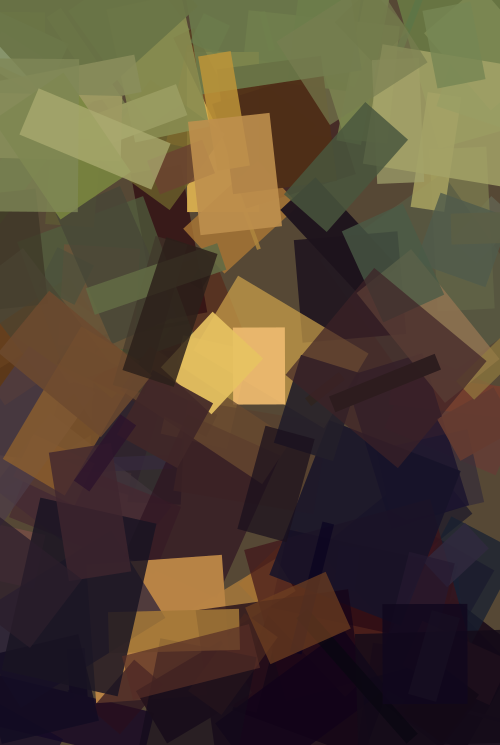

In [10]:
run_experiment(
    IMAGE,
    algo="ga",
    shape="rectangle",
    n_shapes=150,
    time_limit=60,
)

[ 99.5%] refine L1=    8.50 shapes= 150/150 mut=7632/661 ( 8.7%)
Algorithm: greedy
Shapes:    150
Time used: 60.0s
SVG:       outputs/greedy_rectangle_150_60s.svg


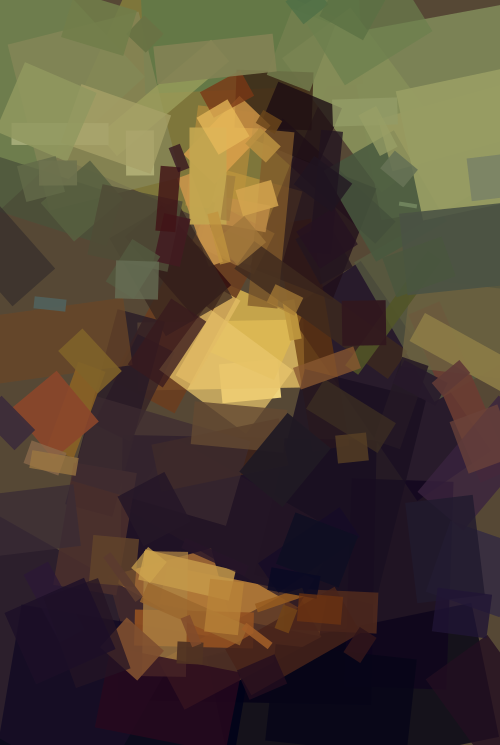

In [6]:
run_experiment(
    IMAGE,
    algo="greedy",
    shape="rectangle",
    n_shapes=150,
    time_limit=60,
)


[ 99.9%] refine L1=    7.47 shapes= 180/180 mut=37586/1415 ( 3.8%)
Algorithm: greedy
Shapes:    180
Time used: 300.0s
SVG:       outputs/greedy_rectangle_180_300s.svg


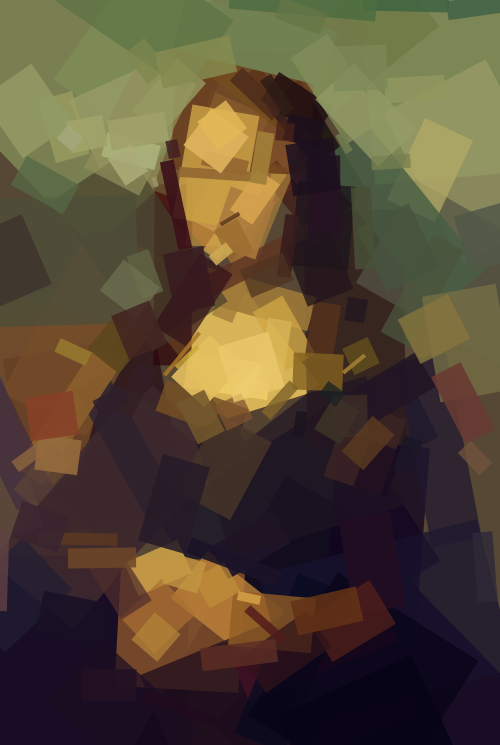

In [7]:
run_experiment(
    IMAGE,
    algo="greedy",
    shape="rectangle",
    n_shapes=180,
    time_limit=300,
)

[ 99.7%] refine L1=    8.68 shapes= 150/150 mut=9378/737 ( 7.9%)
Algorithm: greedy
Shapes:    150
Time used: 60.0s
SVG:       outputs/greedy_rectangle_150_60s.svg


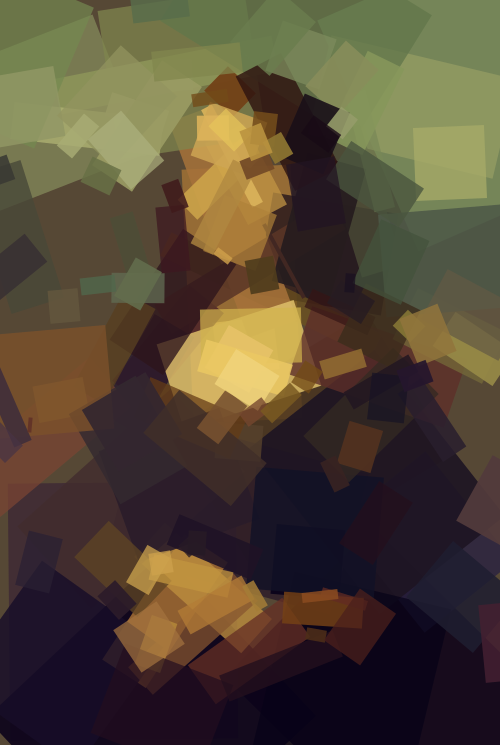

[ 99.5%] refine L1=    8.96 shapes= 150/150 mut=10783/726 ( 6.7%)
Algorithm: greedy
Shapes:    150
Time used: 60.0s
SVG:       outputs/greedy_circle_150_60s.svg


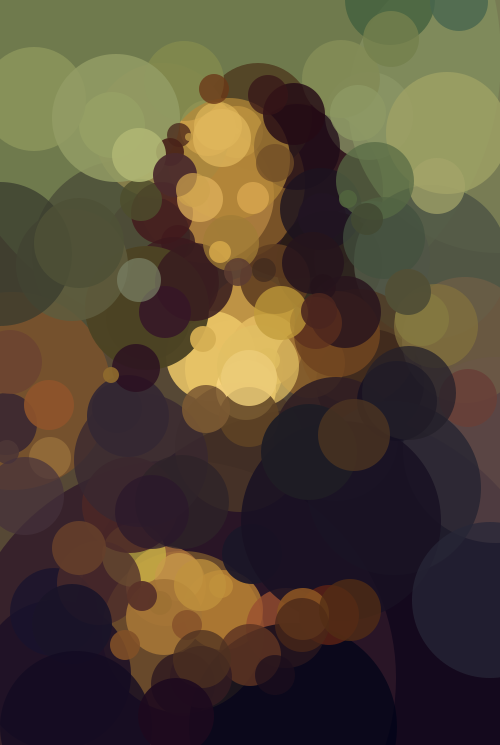

[ 99.6%] refine L1=    8.59 shapes= 150/150 mut=10059/714 ( 7.1%)
Algorithm: greedy
Shapes:    150
Time used: 60.0s
SVG:       outputs/greedy_mixed_150_60s.svg


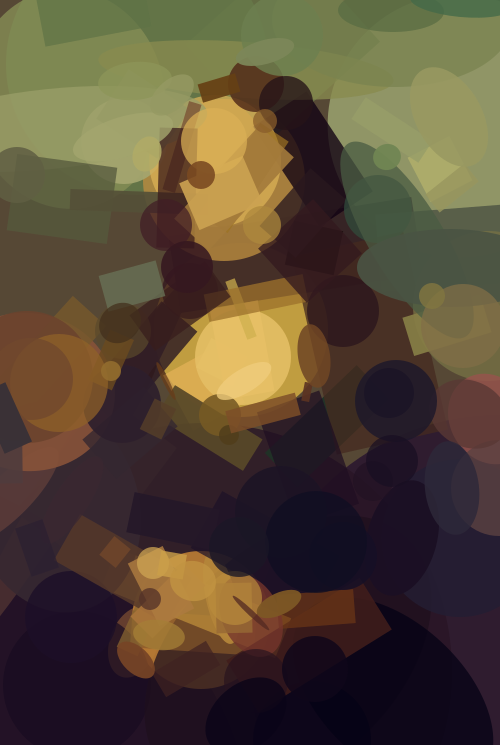

In [8]:
for shape in ["rectangle", "circle", "mixed"]:
    run_experiment(
        IMAGE,
        algo="greedy",
        shape=shape,
        n_shapes=150,
        time_limit=60,
    )

[100.0%] refine L1=    7.80 shapes= 180/180 mut=26346/1155 ( 4.4%)
Algorithm: greedy
Shapes:    180
Time used: 180.0s
SVG:       outputs/greedy_mixed_180_180s.svg


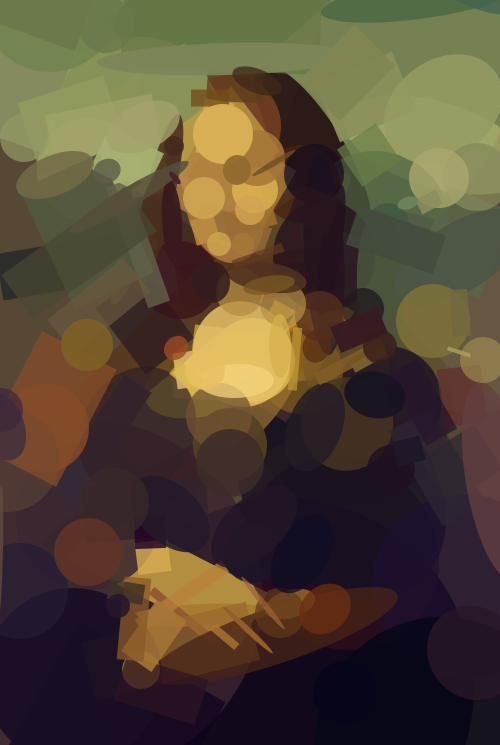

In [11]:
run_experiment(
    IMAGE,
    algo="greedy",
    shape="mixed",
    n_shapes=180,
    time_limit=180,
)

In [12]:
IMAGE = "../images/the_sea_of_fog.jpg"

[100.0%] refine L1=    8.27 shapes= 108/141 mut=3810/527 (13.8%)
Algorithm: greedy
Shapes:    108
Time used: 60.0s
SVG:       outputs/greedy_mixed_141_60s.svg


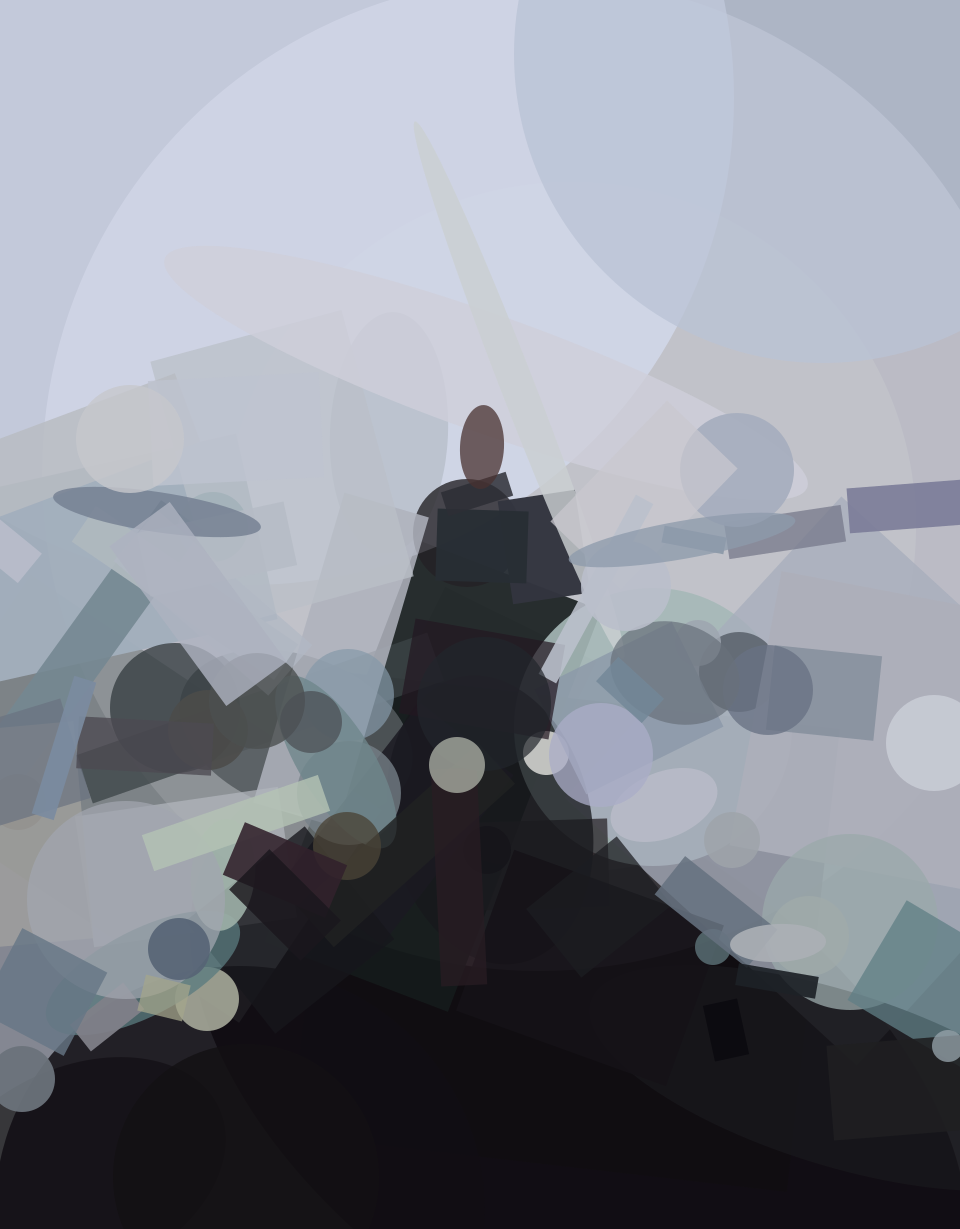

In [14]:
run_experiment(
    IMAGE,
    algo="greedy",
    shape="mixed",
    n_shapes=141,
    time_limit=60,
)